In [1]:
import numpy as np
import tensorflow as tf

# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 

import ipysh
import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

# Load the TensorBoard notebook extension
%load_ext tensorboard

%aimport models.AEFIT5
%aimport models.base
%aimport Dataset_QSH

Hunch models imported
reload set for module  Hunch_utils
reload set for module  Dummy_g1data
reload set for module  Hunch_lsplot
reload set for module  Hunch_tSNEplot


In [2]:
qsh = Dataset_QSH.Dataset_QSH()
import os
file = ipysh.abs_builddir+'/te_db_r15u_shuffle.npy'
if os.path.isfile(file):
    qsh.load(file)
    
qsh.clean_up_poorcurves(5)
qsh.dim = 15
qsh.set_null(np.nan)
qsh.set_normal_positive()
# qsh.unbias_mean(0.5, 'te')
# qsh.set_normal_positive()

# print("QSH rebalanced 15 points size: ", len(qsh))

# qsh.set_null(np.nan)
# qsh.clip_values(0.1,0.6)
# qsh.set_normal_positive()

In [3]:

def encode(self, X, training=None):
    def col_to_zero(tensor, col_to_zero=[]):
        # col_to_zero = [0, 2] # <-- column numbers you want to be zeroed out
        tnsr_shape = tf.shape(tensor)
        mask = [tf.one_hot(col_num*tf.ones((tnsr_shape[0], ), dtype=tf.int32), tnsr_shape[-1])
                for col_num in col_to_zero]
        mask = tf.reduce_sum(mask, axis=0)
        mask = tf.cast(tf.logical_not(tf.cast(mask, tf.bool)), tf.float32)
        return tensor * mask
    
    mean, logvar = tf.split(self.inference_net(X, training=training), num_or_size_splits=2, axis=1)
    mean = col_to_zero(mean, [0])
    one = tf.ones(tf.shape(logvar))
    logvar = col_to_zero(logvar, [0]) + one - col_to_zero(one, [0])
    return mean, logvar

models.AEFIT5.AEFIT5.encode = encode    


In [4]:
ds = qsh.ds_array.map(lambda x,y: (x,x))

ds_train = ds.skip(5000).batch(100, drop_remainder=True)
ds_val   = ds.take(5000).batch(100)

ds_train_len = 0; 
for i in ds_train: ds_train_len += 1
ds_val_len = 0;
for i in ds_val: ds_val_len += 1

In [5]:
class RecordRelevanceDrop(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):        
        R = self.model.generative_net.layers[0].weights[0].numpy()
        for i,r in enumerate(R): self.R_epoch[i].append(r)
        return super().on_epoch_end(epoch, logs=logs)
    
    def on_train_batch_end(self, batch, logs=None):        
        R = self.model.generative_net.layers[0].weights[0].numpy()
        for i,r in enumerate(R): self.R[i].append(r)
        return super().on_train_batch_end(batch, logs=logs)
        
    def set_model(self, model):
        self.model = model        
        self.R = [[] for _ in range(model.latent_dim)]
        self.R_epoch = [[] for _ in range(model.latent_dim)]
        for i in range(model.latent_dim):
            self.R[i].append(1.)
            self.R_epoch[i].append(1.)
        

In [7]:
vae = models.AEFIT5.AEFIT5(latent_dim=3, feature_dim=30, dprate=0., scale=1, beta=1e-6, geometry=[20,20,10,10])

AEFIT5 ready:


In [8]:
class RecordRelevanceDrop(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):        
        R = self.model.generative_net.layers[0].weights[0].numpy()
        for i,r in enumerate(R): self.R_epoch[i].append(r)
        return super().on_epoch_end(epoch, logs=logs)
    
    def on_train_batch_end(self, batch, logs=None):        
        R = self.model.generative_net.layers[0].weights[0].numpy()
        for i,r in enumerate(R): self.R[i].append(r)
        return super().on_train_batch_end(batch, logs=logs)
        
    def set_model(self, model):
        self.model = model        
        self.R = [[] for _ in range(model.latent_dim)]
        self.R_epoch = [[] for _ in range(model.latent_dim)]
        for i in range(model.latent_dim):
            self.R[i].append(1.)
            self.R_epoch[i].append(1.)

In [9]:
h = models.base.RecordMetrics()
hR = RecordRelevanceDrop()

callbacks = [
     h,
     hR,
]

fit = lambda: vae.fit(ds.skip(5000).batch(100, drop_remainder=True), validation_data=ds.take(5000).batch(100), epochs=45, shuffle=False, callbacks=callbacks)
models.base.fn_thread(vae, fit).control_panel()


Epoch 1/45
425/425 [==============================] - 14s 32ms/step - loss: 0.0028 - mse: 0.0028 - akl: 11.4001 - mkl: 7.6180 - b: 1.0000e-06 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_akl: 0.0000e+00 - val_mkl: 0.0000e+00 - val_b: 0.0000e+00
Epoch 2/45
 6/50 [==>...........................] - ETA: 4s - loss: 3.4042e-04 - mse: 3.2966e-04 - akl: 10.7643 - mkl: 8.0692 - b: 1.0000e-06

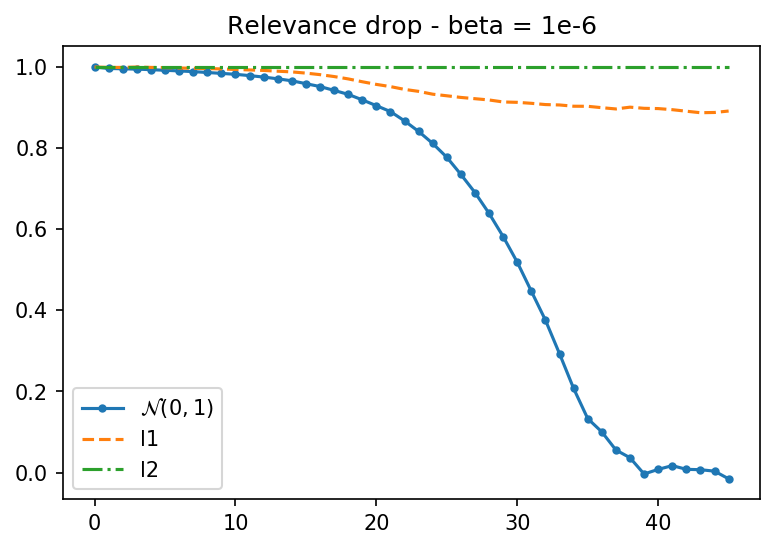

In [60]:
fig = plt.figure('Relevance')
fig.set_dpi(150)
ax = plt.gca()
ax.set_title('Relevance drop - beta = 1e-6')
plt.plot(hR.R_epoch[0], '.-',label='$\mathcal{N}(0,1)$')
plt.plot(hR.R_epoch[1], '--',label='l1')
plt.plot(hR.R_epoch[2], '-.',label='l2')
plt.legend()

In [63]:
def test_fit():
    vae = models.AEFIT5.AEFIT5(latent_dim=3, feature_dim=30, dprate=0., scale=1, beta=1e-6, geometry=[20,20,10,10])
    h = models.base.RecordMetrics()
    hR = RecordRelevanceDrop()
    fit = lambda: vae.fit(ds.skip(5000).batch(100, drop_remainder=True), validation_data=ds.take(5000).batch(100), epochs=45, shuffle=False, callbacks=[h,hR])
    fit()
    return h,hR

h = []
hR = []
for i in range(10):
    print('************************* ITERATION: ',i)
    _h, _hR = test_fit()
    h.append(_h)
    hR.append(_hR)




************************* ITERATION:  0
AEFIT5 ready:
Epoch 1/45
425/425 [==============================] - 13s 31ms/step - loss: 0.0032 - mse: 0.0032 - akl: 7.1720 - mkl: 6.3019 - b: 1.0000e-06 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_akl: 0.0000e+00 - val_mkl: 0.0000e+00 - val_b: 0.0000e+00
Epoch 2/45
425/425 [==============================] - 11s 26ms/step - loss: 3.4098e-04 - mse: 3.3317e-04 - akl: 8.4980 - mkl: 7.9780 - b: 1.0000e-06 - val_loss: 3.1288e-04 - val_mse: 3.0528e-04 - val_akl: 7.6013 - val_mkl: 7.2382 - val_b: 1.0000e-06
Epoch 3/45
425/425 [==============================] - 11s 26ms/step - loss: 2.4537e-04 - mse: 2.2752e-04 - akl: 8.8872 - mkl: 8.6208 - b: 1.0000e-06 - val_loss: 1.9395e-04 - val_mse: 1.8506e-04 - val_akl: 8.8909 - val_mkl: 8.7827 - val_b: 1.0000e-06
Epoch 4/45
425/425 [==============================] - 11s 26ms/step - loss: 1.9908e-04 - mse: 1.8901e-04 - akl: 8.6183 - mkl: 8.6098 - b: 1.0000e-06 - val_loss: 2.0093e-04 - val_mse: 1.9256e-04 - 

425/425 [==============================] - 11s 26ms/step - loss: 1.6682e-04 - mse: 1.5950e-04 - akl: 7.9785 - mkl: 8.0540 - b: 1.0000e-06 - val_loss: 1.6124e-04 - val_mse: 1.5342e-04 - val_akl: 7.8173 - val_mkl: 7.8714 - val_b: 1.0000e-06
Epoch 34/45
425/425 [==============================] - 11s 26ms/step - loss: 1.5894e-04 - mse: 1.5123e-04 - akl: 7.9850 - mkl: 8.0518 - b: 1.0000e-06 - val_loss: 1.5960e-04 - val_mse: 1.5161e-04 - val_akl: 7.9905 - val_mkl: 8.0833 - val_b: 1.0000e-06
Epoch 35/45
425/425 [==============================] - 11s 26ms/step - loss: 1.6113e-04 - mse: 1.5360e-04 - akl: 7.9753 - mkl: 8.0297 - b: 1.0000e-06 - val_loss: 1.5917e-04 - val_mse: 1.5125e-04 - val_akl: 7.9189 - val_mkl: 8.0030 - val_b: 1.0000e-06
Epoch 36/45
425/425 [==============================] - 11s 26ms/step - loss: 1.6068e-04 - mse: 1.5347e-04 - akl: 8.0464 - mkl: 8.0872 - b: 1.0000e-06 - val_loss: 1.5562e-04 - val_mse: 1.4782e-04 - val_akl: 7.8036 - val_mkl: 7.8886 - val_b: 1.0000e-06
Epoch 37

425/425 [==============================] - 11s 26ms/step - loss: 1.7058e-04 - mse: 1.6322e-04 - akl: 7.8650 - mkl: 8.0977 - b: 1.0000e-06 - val_loss: 1.6409e-04 - val_mse: 1.5600e-04 - val_akl: 8.0803 - val_mkl: 8.2842 - val_b: 1.0000e-06
Epoch 21/45
425/425 [==============================] - 11s 26ms/step - loss: 1.6661e-04 - mse: 1.5934e-04 - akl: 7.8876 - mkl: 8.1252 - b: 1.0000e-06 - val_loss: 1.6547e-04 - val_mse: 1.5753e-04 - val_akl: 7.9386 - val_mkl: 8.1589 - val_b: 1.0000e-06
Epoch 22/45
425/425 [==============================] - 11s 26ms/step - loss: 1.6813e-04 - mse: 1.6004e-04 - akl: 7.8703 - mkl: 8.0995 - b: 1.0000e-06 - val_loss: 1.6212e-04 - val_mse: 1.5419e-04 - val_akl: 7.9332 - val_mkl: 8.1685 - val_b: 1.0000e-06
Epoch 23/45
425/425 [==============================] - 11s 26ms/step - loss: 1.6512e-04 - mse: 1.5755e-04 - akl: 7.8740 - mkl: 8.1112 - b: 1.0000e-06 - val_loss: 1.6101e-04 - val_mse: 1.5293e-04 - val_akl: 8.0803 - val_mkl: 8.2577 - val_b: 1.0000e-06
Epoch 24

425/425 [==============================] - 11s 26ms/step - loss: 1.8892e-04 - mse: 1.7919e-04 - akl: 8.8136 - mkl: 8.6966 - b: 1.0000e-06 - val_loss: 1.8102e-04 - val_mse: 1.7247e-04 - val_akl: 8.5491 - val_mkl: 8.5201 - val_b: 1.0000e-06
Epoch 8/45
425/425 [==============================] - 11s 26ms/step - loss: 1.8497e-04 - mse: 1.7575e-04 - akl: 8.5868 - mkl: 8.5780 - b: 1.0000e-06 - val_loss: 2.0376e-04 - val_mse: 1.9526e-04 - val_akl: 8.5007 - val_mkl: 8.5053 - val_b: 1.0000e-06
Epoch 9/45
425/425 [==============================] - 11s 26ms/step - loss: 1.8147e-04 - mse: 1.7230e-04 - akl: 8.4751 - mkl: 8.5551 - b: 1.0000e-06 - val_loss: 1.7294e-04 - val_mse: 1.6461e-04 - val_akl: 8.3305 - val_mkl: 8.4503 - val_b: 1.0000e-06
Epoch 10/45
425/425 [==============================] - 11s 26ms/step - loss: 1.8303e-04 - mse: 1.7364e-04 - akl: 8.3204 - mkl: 8.4490 - b: 1.0000e-06 - val_loss: 1.8996e-04 - val_mse: 1.8159e-04 - val_akl: 8.3691 - val_mkl: 8.4973 - val_b: 1.0000e-06
Epoch 11/4

Epoch 40/45
425/425 [==============================] - 11s 25ms/step - loss: 1.5693e-04 - mse: 1.4871e-04 - akl: 8.1183 - mkl: 8.1968 - b: 1.0000e-06 - val_loss: 1.4769e-04 - val_mse: 1.3948e-04 - val_akl: 8.2053 - val_mkl: 8.3595 - val_b: 1.0000e-06
Epoch 41/45
425/425 [==============================] - 11s 25ms/step - loss: 1.5205e-04 - mse: 1.4427e-04 - akl: 8.1417 - mkl: 8.2591 - b: 1.0000e-06 - val_loss: 1.4831e-04 - val_mse: 1.4009e-04 - val_akl: 8.2243 - val_mkl: 8.3456 - val_b: 1.0000e-06
Epoch 42/45
425/425 [==============================] - 10s 24ms/step - loss: 1.6090e-04 - mse: 1.5309e-04 - akl: 8.1697 - mkl: 8.2460 - b: 1.0000e-06 - val_loss: 1.5291e-04 - val_mse: 1.4470e-04 - val_akl: 8.2091 - val_mkl: 8.2214 - val_b: 1.0000e-06
Epoch 43/45
425/425 [==============================] - 10s 24ms/step - loss: 1.6459e-04 - mse: 1.5855e-04 - akl: 8.2298 - mkl: 8.2930 - b: 1.0000e-06 - val_loss: 1.5973e-04 - val_mse: 1.5179e-04 - val_akl: 7.9407 - val_mkl: 7.9636 - val_b: 1.0000e

425/425 [==============================] - 10s 24ms/step - loss: 1.6907e-04 - mse: 1.6098e-04 - akl: 7.9165 - mkl: 8.1422 - b: 1.0000e-06 - val_loss: 1.6392e-04 - val_mse: 1.5606e-04 - val_akl: 7.8606 - val_mkl: 8.0743 - val_b: 1.0000e-06
Epoch 28/45
425/425 [==============================] - 10s 24ms/step - loss: 1.6715e-04 - mse: 1.5927e-04 - akl: 7.9179 - mkl: 8.1429 - b: 1.0000e-06 - val_loss: 1.6333e-04 - val_mse: 1.5557e-04 - val_akl: 7.7598 - val_mkl: 7.9253 - val_b: 1.0000e-06
Epoch 29/45
425/425 [==============================] - 10s 24ms/step - loss: 1.6646e-04 - mse: 1.5857e-04 - akl: 7.8854 - mkl: 8.0868 - b: 1.0000e-06 - val_loss: 1.6248e-04 - val_mse: 1.5474e-04 - val_akl: 7.7437 - val_mkl: 7.9869 - val_b: 1.0000e-06
Epoch 30/45
425/425 [==============================] - 10s 24ms/step - loss: 1.6695e-04 - mse: 1.5935e-04 - akl: 7.8758 - mkl: 8.0488 - b: 1.0000e-06 - val_loss: 1.7084e-04 - val_mse: 1.6293e-04 - val_akl: 7.9100 - val_mkl: 8.0197 - val_b: 1.0000e-06
Epoch 31

425/425 [==============================] - 10s 24ms/step - loss: 1.8716e-04 - mse: 1.7512e-04 - akl: 8.2171 - mkl: 8.4217 - b: 1.0000e-06 - val_loss: 1.7018e-04 - val_mse: 1.6194e-04 - val_akl: 8.2382 - val_mkl: 8.4745 - val_b: 1.0000e-06
Epoch 15/45
425/425 [==============================] - 10s 25ms/step - loss: 1.7380e-04 - mse: 1.6538e-04 - akl: 8.2007 - mkl: 8.4252 - b: 1.0000e-06 - val_loss: 1.6981e-04 - val_mse: 1.6169e-04 - val_akl: 8.1193 - val_mkl: 8.3687 - val_b: 1.0000e-06
Epoch 16/45
425/425 [==============================] - 11s 25ms/step - loss: 1.7301e-04 - mse: 1.6467e-04 - akl: 8.1165 - mkl: 8.3580 - b: 1.0000e-06 - val_loss: 1.7185e-04 - val_mse: 1.6381e-04 - val_akl: 8.0404 - val_mkl: 8.3143 - val_b: 1.0000e-06
Epoch 17/45
425/425 [==============================] - 10s 25ms/step - loss: 1.7272e-04 - mse: 1.6435e-04 - akl: 8.0599 - mkl: 8.3061 - b: 1.0000e-06 - val_loss: 1.7426e-04 - val_mse: 1.6628e-04 - val_akl: 7.9740 - val_mkl: 8.2426 - val_b: 1.0000e-06
Epoch 18

Epoch 2/45
425/425 [==============================] - 11s 25ms/step - loss: 2.8324e-04 - mse: 2.6506e-04 - akl: 10.8591 - mkl: 9.4520 - b: 1.0000e-06 - val_loss: 1.9927e-04 - val_mse: 1.8885e-04 - val_akl: 10.4244 - val_mkl: 9.3946 - val_b: 1.0000e-06
Epoch 3/45
425/425 [==============================] - 11s 25ms/step - loss: 2.1022e-04 - mse: 1.9825e-04 - akl: 10.3265 - mkl: 9.5139 - b: 1.0000e-06 - val_loss: 2.2113e-04 - val_mse: 2.1126e-04 - val_akl: 9.8771 - val_mkl: 9.2514 - val_b: 1.0000e-06
Epoch 4/45
425/425 [==============================] - 11s 25ms/step - loss: 2.0383e-04 - mse: 1.9249e-04 - akl: 9.4236 - mkl: 8.9605 - b: 1.0000e-06 - val_loss: 1.8322e-04 - val_mse: 1.7420e-04 - val_akl: 9.0167 - val_mkl: 8.7127 - val_b: 1.0000e-06
Epoch 5/45
425/425 [==============================] - 11s 25ms/step - loss: 1.9096e-04 - mse: 1.8151e-04 - akl: 8.8737 - mkl: 8.6693 - b: 1.0000e-06 - val_loss: 1.9933e-04 - val_mse: 1.9060e-04 - val_akl: 8.7338 - val_mkl: 8.5817 - val_b: 1.0000e-

Epoch 35/45
425/425 [==============================] - 12s 29ms/step - loss: 1.5795e-04 - mse: 1.5042e-04 - akl: 8.0299 - mkl: 8.1555 - b: 1.0000e-06 - val_loss: 1.5737e-04 - val_mse: 1.4928e-04 - val_akl: 8.0836 - val_mkl: 8.2293 - val_b: 1.0000e-06
Epoch 36/45
425/425 [==============================] - 12s 28ms/step - loss: 1.6066e-04 - mse: 1.5327e-04 - akl: 8.0783 - mkl: 8.1676 - b: 1.0000e-06 - val_loss: 1.5109e-04 - val_mse: 1.4294e-04 - val_akl: 8.1566 - val_mkl: 8.2700 - val_b: 1.0000e-06
Epoch 37/45
425/425 [==============================] - 12s 29ms/step - loss: 1.5496e-04 - mse: 1.4737e-04 - akl: 8.1396 - mkl: 8.2358 - b: 1.0000e-06 - val_loss: 1.5499e-04 - val_mse: 1.4704e-04 - val_akl: 7.9519 - val_mkl: 8.0326 - val_b: 1.0000e-06
Epoch 38/45
425/425 [==============================] - 12s 27ms/step - loss: 1.5559e-04 - mse: 1.4766e-04 - akl: 8.1687 - mkl: 8.2873 - b: 1.0000e-06 - val_loss: 1.7115e-04 - val_mse: 1.6302e-04 - val_akl: 8.1287 - val_mkl: 8.1196 - val_b: 1.0000e

425/425 [==============================] - 11s 27ms/step - loss: 1.6757e-04 - mse: 1.5990e-04 - akl: 7.8432 - mkl: 8.0917 - b: 1.0000e-06 - val_loss: 1.6416e-04 - val_mse: 1.5631e-04 - val_akl: 7.8515 - val_mkl: 8.0234 - val_b: 1.0000e-06
Epoch 23/45
425/425 [==============================] - 11s 26ms/step - loss: 1.6421e-04 - mse: 1.5658e-04 - akl: 7.8462 - mkl: 8.0671 - b: 1.0000e-06 - val_loss: 1.7313e-04 - val_mse: 1.6528e-04 - val_akl: 7.8415 - val_mkl: 7.9948 - val_b: 1.0000e-06
Epoch 24/45
425/425 [==============================] - 11s 26ms/step - loss: 1.6666e-04 - mse: 1.5911e-04 - akl: 7.8443 - mkl: 8.0568 - b: 1.0000e-06 - val_loss: 1.5886e-04 - val_mse: 1.5125e-04 - val_akl: 7.6153 - val_mkl: 7.8548 - val_b: 1.0000e-06
Epoch 25/45
425/425 [==============================] - 11s 27ms/step - loss: 1.6391e-04 - mse: 1.5629e-04 - akl: 7.8547 - mkl: 8.0864 - b: 1.0000e-06 - val_loss: 1.6399e-04 - val_mse: 1.5633e-04 - val_akl: 7.6650 - val_mkl: 7.9119 - val_b: 1.0000e-06
Epoch 26

425/425 [==============================] - 11s 26ms/step - loss: 1.8673e-04 - mse: 1.7621e-04 - akl: 8.2037 - mkl: 8.3822 - b: 1.0000e-06 - val_loss: 1.7311e-04 - val_mse: 1.6496e-04 - val_akl: 8.1490 - val_mkl: 8.3537 - val_b: 1.0000e-06
Epoch 10/45
425/425 [==============================] - 11s 26ms/step - loss: 1.8160e-04 - mse: 1.7311e-04 - akl: 8.1022 - mkl: 8.3061 - b: 1.0000e-06 - val_loss: 1.7361e-04 - val_mse: 1.6549e-04 - val_akl: 8.1211 - val_mkl: 8.3354 - val_b: 1.0000e-06
Epoch 11/45
425/425 [==============================] - 11s 26ms/step - loss: 1.7913e-04 - mse: 1.7071e-04 - akl: 8.0560 - mkl: 8.2752 - b: 1.0000e-06 - val_loss: 1.7760e-04 - val_mse: 1.6955e-04 - val_akl: 8.0473 - val_mkl: 8.3084 - val_b: 1.0000e-06
Epoch 12/45
425/425 [==============================] - 13s 31ms/step - loss: 1.7779e-04 - mse: 1.6960e-04 - akl: 7.9936 - mkl: 8.2282 - b: 1.0000e-06 - val_loss: 1.7469e-04 - val_mse: 1.6675e-04 - val_akl: 7.9433 - val_mkl: 8.2126 - val_b: 1.0000e-06
Epoch 13

Epoch 42/45
425/425 [==============================] - 12s 28ms/step - loss: 1.6657e-04 - mse: 1.5844e-04 - akl: 8.1972 - mkl: 8.2426 - b: 1.0000e-06 - val_loss: 1.6349e-04 - val_mse: 1.5543e-04 - val_akl: 8.0593 - val_mkl: 8.0865 - val_b: 1.0000e-06
Epoch 43/45
425/425 [==============================] - 11s 27ms/step - loss: 1.6163e-04 - mse: 1.5272e-04 - akl: 8.2209 - mkl: 8.2627 - b: 1.0000e-06 - val_loss: 1.5549e-04 - val_mse: 1.4727e-04 - val_akl: 8.2137 - val_mkl: 8.2742 - val_b: 1.0000e-06
Epoch 44/45
425/425 [==============================] - 11s 27ms/step - loss: 1.5883e-04 - mse: 1.5074e-04 - akl: 8.2380 - mkl: 8.2591 - b: 1.0000e-06 - val_loss: 1.5529e-04 - val_mse: 1.4720e-04 - val_akl: 8.0916 - val_mkl: 8.0781 - val_b: 1.0000e-06
Epoch 45/45
425/425 [==============================] - 11s 26ms/step - loss: 1.6345e-04 - mse: 1.5550e-04 - akl: 8.3392 - mkl: 8.3637 - b: 1.0000e-06 - val_loss: 2.1058e-04 - val_mse: 2.0158e-04 - val_akl: 9.0009 - val_mkl: 8.8179 - val_b: 1.0000e

425/425 [==============================] - 11s 27ms/step - loss: 1.6313e-04 - mse: 1.5484e-04 - akl: 7.8564 - mkl: 8.0664 - b: 1.0000e-06 - val_loss: 1.6198e-04 - val_mse: 1.5404e-04 - val_akl: 7.9482 - val_mkl: 8.1650 - val_b: 1.0000e-06
Epoch 30/45
425/425 [==============================] - 12s 27ms/step - loss: 1.6221e-04 - mse: 1.5518e-04 - akl: 7.9008 - mkl: 8.1048 - b: 1.0000e-06 - val_loss: 1.5591e-04 - val_mse: 1.4794e-04 - val_akl: 7.9689 - val_mkl: 8.0703 - val_b: 1.0000e-06
Epoch 31/45
425/425 [==============================] - 12s 27ms/step - loss: 1.6032e-04 - mse: 1.5261e-04 - akl: 7.9320 - mkl: 8.0946 - b: 1.0000e-06 - val_loss: 1.5348e-04 - val_mse: 1.4539e-04 - val_akl: 8.0960 - val_mkl: 8.2847 - val_b: 1.0000e-06
Epoch 32/45
425/425 [==============================] - 12s 28ms/step - loss: 1.6321e-04 - mse: 1.5600e-04 - akl: 7.9747 - mkl: 8.1232 - b: 1.0000e-06 - val_loss: 1.6208e-04 - val_mse: 1.5388e-04 - val_akl: 8.2054 - val_mkl: 8.3555 - val_b: 1.0000e-06
Epoch 33

425/425 [==============================] - 12s 27ms/step - loss: 1.7841e-04 - mse: 1.6917e-04 - akl: 8.1556 - mkl: 8.3261 - b: 1.0000e-06 - val_loss: 1.7059e-04 - val_mse: 1.6247e-04 - val_akl: 8.1250 - val_mkl: 8.3447 - val_b: 1.0000e-06
Epoch 17/45
425/425 [==============================] - 12s 28ms/step - loss: 1.7213e-04 - mse: 1.6388e-04 - akl: 8.1203 - mkl: 8.3106 - b: 1.0000e-06 - val_loss: 1.6826e-04 - val_mse: 1.6010e-04 - val_akl: 8.1521 - val_mkl: 8.3393 - val_b: 1.0000e-06
Epoch 18/45
425/425 [==============================] - 12s 28ms/step - loss: 1.7282e-04 - mse: 1.6434e-04 - akl: 8.0857 - mkl: 8.2720 - b: 1.0000e-06 - val_loss: 1.8007e-04 - val_mse: 1.7197e-04 - val_akl: 8.1044 - val_mkl: 8.3290 - val_b: 1.0000e-06
Epoch 19/45
425/425 [==============================] - 12s 28ms/step - loss: 1.7182e-04 - mse: 1.6366e-04 - akl: 8.0553 - mkl: 8.2307 - b: 1.0000e-06 - val_loss: 1.6806e-04 - val_mse: 1.5990e-04 - val_akl: 8.1573 - val_mkl: 8.3796 - val_b: 1.0000e-06
Epoch 20

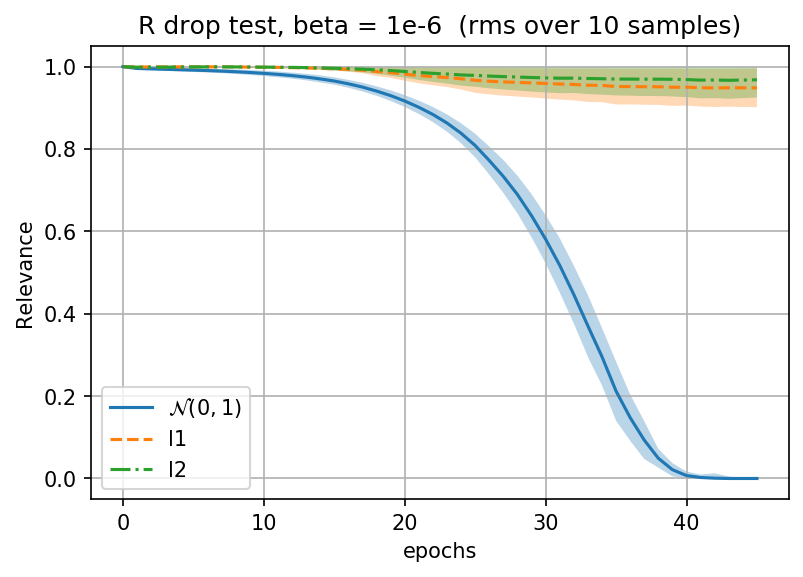

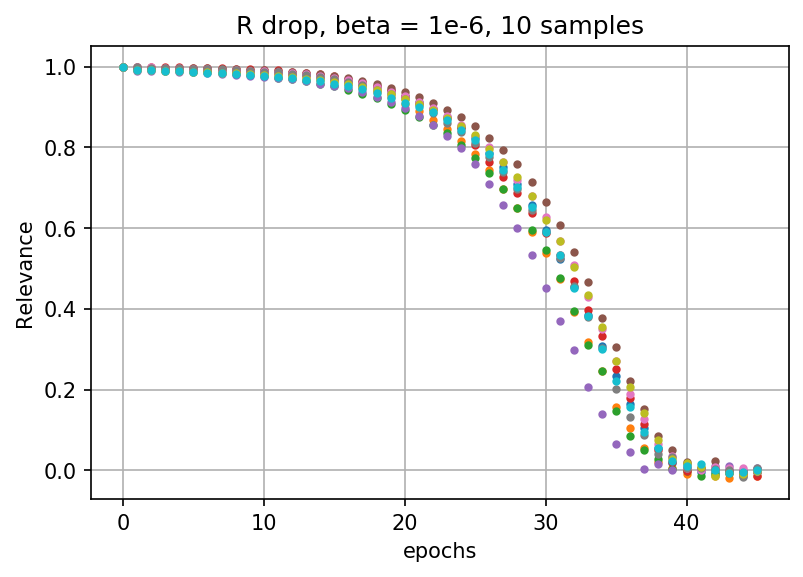

In [101]:
from Hunch_utils import Stat2
def pt_analize(hx):
    st = Stat2()
    for x in hx: st += x
    return st.mean(), st.rms()

def get_mv(h, lv):
    m = []
    v = []
    for i in range(len(h[0].R_epoch[0])):
        hx = [ x.R_epoch[lv][i] for x in h[:] ]
        _m,_v = pt_analize(hx)
        m.append(_m)
        v.append(_v)
    return np.array(m),np.array(v)
    
def plot_mv(h,lv, label, tag='-'):
    def clip(x):
        return np.clip(x, a_max=1., a_min=0.)
    m,v = get_mv(h,lv)
    x = range(len(m))
    plt.plot(x, clip(m) , tag, label=label)
    plt.fill_between(x, clip(m+v), clip(m-v), alpha=0.3)

fig = plt.figure('R')
fig.set_dpi(150)
ax = plt.gca()
ax.set_title('R drop test, beta = 1e-6  (rms over 10 samples)')
ax.grid(True)
plt.xlabel('epochs')
plt.ylabel('Relevance')
plot_mv(hR,0,'$\mathcal{N}(0,1)$')
plot_mv(hR,1,'l1','--')
plot_mv(hR,2,'l2','-.')
plt.legend()

fig = plt.figure('R_samples')
fig.set_dpi(150)
ax = plt.gca()
ax.grid(True)
ax.set_title('R drop, beta = 1e-6, 10 samples')
plt.xlabel('epochs')
plt.ylabel('Relevance')
for i in range(10):
    plt.plot(hR[i].R_epoch[0],'.')


# get_mv(hR, 0)
